In [2]:
# libraries for model 
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import pygeohash as gh
from sklearn.metrics import mean_squared_error

In [3]:
# Funtion for cross-validation over a grid of parameters

def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None, verbose=0):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func, verbose=verbose)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds, verbose=verbose)
    gs.fit(X, y)
    print ("BEST", gs.best_params_, gs.best_score_, gs.cv_results_, gs.scorer_)
    print ("Best score: ", gs.best_score_)
    best = gs.best_estimator_
    return best

In [4]:
bird = pd.read_csv("bird_data_pickups.csv")
bird = bird.drop(['day'], axis=1)
bird.head()

,geohash,day_of_week,weekend,hour,minute,n
0,9q59x8,5,0,21,10,75
1,9q59x8,5,0,21,20,72
2,9q59x8,5,0,21,5,71
3,9q59x8,5,0,21,15,70
4,9q59x8,5,0,21,0,68


In [10]:
#split dataset in features and target variable
feature_cols = [ 'geohash','day_of_week', 'weekend','hour','minute'] # remove 'geohash'
X = bird[feature_cols] # Features
y = bird.n # Target variable

In [11]:
# Get the longitude and latitude from the geohash
def decodegeo(geo, which):
    if len(geo) >= 6:
        geodecoded = gh.decode(geo)
        return geodecoded[which]
    else:
        return 0
X['latitude'] = X['geohash'].apply(lambda geo: decodegeo(geo, 0))
X['longitude'] = X['geohash'].apply(lambda geo: decodegeo(geo, 1))
X.head()
X = X.drop(['geohash'], axis=1)

In [13]:
X.day_of_week.unique()

array([5, 3, 6, 2, 4])

In [14]:
X_train =  X[(X['day_of_week'] != 3) & (X['day_of_week'] != 5) ]
print("Train set:", X_train.shape)

X_test = X[(X['day_of_week'] == 3) | (X['day_of_week'] == 5) ]
print( "Test set:", X_test.shape)

y_train = y.loc[X_train.index.values]
y_test = y.loc[X_test.index.values]

# X_train = X_train.drop(['day_of_week'], axis=1)
# X_test = X_test.drop(['day_of_week'], axis=1)
print(X_train.head())
print(X_test.head())

Train set: (922, 6)
Test set: (641, 6)
    day_of_week  weekend  hour  minute   latitude   longitude
68            6        1    23      25  34.021912 -118.493042
71            6        1    23      20  34.021912 -118.493042
73            6        1    23      10  34.021912 -118.493042
74            6        1    23      15  34.021912 -118.493042
75            6        1    23      30  34.021912 -118.493042
   day_of_week  weekend  hour  minute   latitude   longitude
0            5        0    21      10  34.016418 -118.493042
1            5        0    21      20  34.016418 -118.493042
2            5        0    21       5  34.016418 -118.493042
3            5        0    21      15  34.016418 -118.493042
4            5        0    21       0  34.016418 -118.493042


In [15]:
# Create a Random Forest Regression estimator
estimator = RandomForestRegressor(n_estimators=20, n_jobs=-1)

In [16]:
# Define a grid of parameters over which to optimize the random forest
# We will figure out which number of trees is optimal
parameters = {"n_estimators": [10],
              "max_features": ["auto"], # ["auto","sqrt","log2"]
              "max_depth": [3]}
best = cv_optimize(estimator, parameters, X_train, y_train, n_folds=5, score_func='neg_mean_absolute_error', verbose=3)



Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] max_depth=3, max_features=auto, n_estimators=10 .................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=3, max_features=auto, n_estimators=10, score=-16.450, total=   1.4s
[CV] max_depth=3, max_features=auto, n_estimators=10 .................
[CV]  max_depth=3, max_features=auto, n_estimators=10, score=-7.414, total=   0.1s
[CV] max_depth=3, max_features=auto, n_estimators=10 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV]  max_depth=3, max_features=auto, n_estimators=10, score=-6.600, total=   0.1s
[CV] max_depth=3, max_features=auto, n_estimators=10 .................
[CV]  max_depth=3, max_features=auto, n_estimators=10, score=-10.166, total=   0.1s
[CV] max_depth=3, max_features=auto, n_estimators=10 .................
[CV]  max_depth=3, max_features=auto, n_estimators=10, score=-4.637, total=   0.1s
BEST {'max_depth': 3, 'max_features': 'auto', 'n_estimators': 10} -9.059749256256111 {'mean_fit_time': array([0.26883898]), 'std_fit_time': array([0.49970543]), 'mean_score_time': array([0.10852609]), 'std_score_time': array([0.0046554]), 'param_max_depth': masked_array(data=[3],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_max_features': masked_array(data=['auto'],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[10],
             mask=[False],
       fill_value='?',
            dtype=object), 

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.9s finished
//anaconda/envs/bird_view/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [17]:
# Fit the best Random Forest and calculate R^2 values for training and test sets
reg=best.fit(X_train, y_train)
training_accuracy = reg.score(X_train, y_train)
test_accuracy = reg.score(X_test, y_test)
print( "############# based on standard predict ################")
print ("R^2 on training data: %0.4f" % (training_accuracy))
print ("R^2 on test data:     %0.4f" % (test_accuracy))

############# based on standard predict ################
R^2 on training data: 0.8019
R^2 on test data:     0.7119


In [18]:
# Show some of the predictions vs. the real number of pickups
# predictions vs. real number of pickups
np.column_stack((reg.predict(X_test),y_test))

array([[36.1555514 , 75.        ],
       [36.1555514 , 72.        ],
       [36.1555514 , 71.        ],
       ...,
       [ 3.43724408,  1.        ],
       [ 3.43724408,  1.        ],
       [ 3.43724408,  1.        ]])

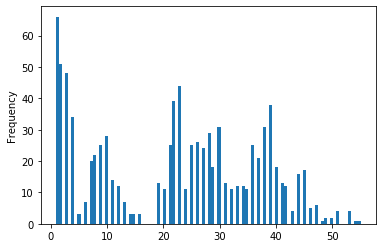

In [19]:
fig, ax = plt.subplots()

y_train.plot(kind='hist', bins=100)

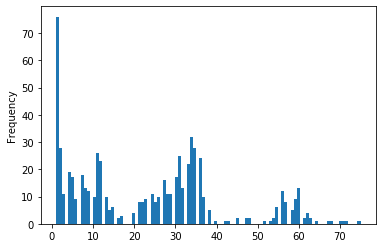

In [20]:
fig, ax = plt.subplots()

y_test.plot(kind='hist', bins=100)

In [21]:
# Calculate the Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(reg.predict(X_test),y_test))
print ("RMSE = %0.3f" % rmse)

RMSE = 9.716


In [22]:
# What are the most important features?
import operator
dict_feat_imp = dict(zip(list(X.columns.values),reg.feature_importances_))

sorted_features = sorted(dict_feat_imp.items(), key=operator.itemgetter(1), reverse=True)
sorted_features

[('longitude', 0.6228593369925101),
 ('latitude', 0.3665689077291868),
 ('weekend', 0.008942351189746045),
 ('day_of_week', 0.0016268236834852442),
 ('hour', 1.6671827481722628e-06),
 ('minute', 9.132223236439127e-07)]

In [92]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

#get decision tree output 
rf_viz = best.estimators_[5]
dot_data = StringIO()
export_graphviz(rf_viz, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())
graph.write_pdf("tree.pdf")

True

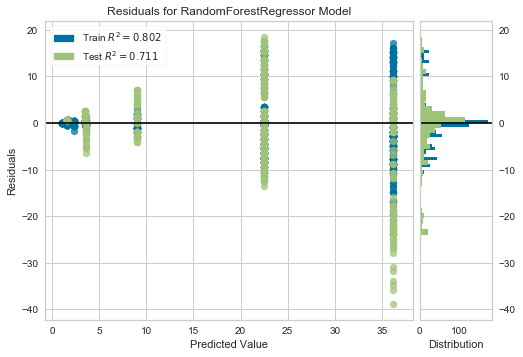

In [93]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(best, hist=True)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

In [94]:
importances = best.feature_importances_

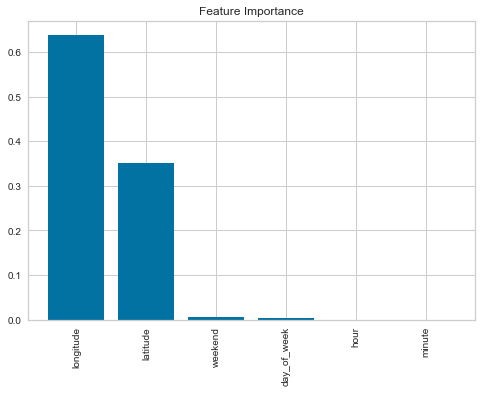

In [95]:
import matplotlib.pyplot as plt
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]
features_names = ['day_of_week', 'weekend', 'hour', 'minute', 'latitude', 'longitude']
# Rearrange feature names so they match the sorted feature importances
names = [features_names[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90)

# Show plot
plt.show()